# Find the first excited state of H$_2$

In the following example we will use Qulacs to simulate a noise quantum circuit

In [1]:
import qulacs
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.transforms import get_sparse_operator
from openfermion.hamiltonians import MolecularData
from openfermionpyscf import run_pyscf
from scipy.optimize import minimize
from pyscf import fci
import numpy as np
import matplotlib.pyplot as plt

We have already shown how to find the fundamental state with VQE. We will use this same method for finding the first excited state. Knowing excited states is useful for calculating energy spectra for emission and absorption experiments and for many other applications.

We will use sto-3g basis to describe the 4 qubit Hamiltonian. Our algorithm will be equal to the VQE we have implemented, but we will begin by defining a set of orthogonal states. In this case, we will select $|0000\rangle$ (the one we normally use) and $|0001\rangle$ (for finding the excited state).

In [2]:
from scipy.sparse.linalg import eigsh
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text


basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.977
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"
molecule = MolecularData(geometry, basis, multiplicity, charge, description)
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
n_qubit = molecule.n_qubits
n_electron = molecule.n_electrons
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
hamiltonian_matrix = get_sparse_operator(jw_hamiltonian)

eigval, eigvec = eigsh(hamiltonian_matrix, k=2, which="SA")

qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

We will now construct the ansatz

In [3]:
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RY, RZ, merge

depth = n_qubit

In [4]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    """he_ansatz_circuit
    Returns hardware efficient ansatz circuit.

    Args:
        n_qubit (:class:`int`):
            the number of qubit used (equivalent to the number of fermionic modes)
        depth (:class:`int`):
            depth of the circuit.
        theta_list (:class:`numpy.ndarray`):
            rotation angles.
    Returns:
        :class:`qulacs.QuantumCircuit`
    """
    circuit = QuantumCircuit(n_qubit)
    circuit.add_gate(RY(0, theta_list[-2]))
    circuit.add_gate(RZ(0, theta_list[-1]))
    for d in range(depth):
        for i in range(n_qubit):
            circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*d]), RZ(i, theta_list[2*i+1+2*n_qubit*d])))
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
    for i in range(n_qubit):
        circuit.add_gate(merge(RY(i, theta_list[2*i+2*n_qubit*depth]), RZ(i, theta_list[2*i+1+2*n_qubit*depth])))

    return circuit

Define the cost function

In [5]:
def get_exp(state, theta_list):
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list) #Create quantum circuit
    circuit.update_quantum_state(state) #Operate on quantum state
    return qulacs_hamiltonian.get_expectation_value(state)

def cost(theta_list):
    state0 = QuantumState(n_qubit) #Prepare |00000>
    state1 = QuantumState(n_qubit); state1.set_computational_basis(1) #Prepare |00001>
    return get_exp(state0, theta_list)+0.5*get_exp(state1, theta_list)

init_theta_list = np.random.random(2*n_qubit*(depth+1)+2)*1e-1
cost(init_theta_list)

0.21320934470253927

Now we iterate and optimize using BFGS method from scipy

In [7]:
exp_history0 = []
exp_history1 = []
def callback(theta_list):
    state0 = QuantumState(n_qubit) #Prepare |0000>
    state1 = QuantumState(n_qubit); state1.set_computational_basis(1) #Prepare |0001>
    exp_history0.append(get_exp(state0, theta_list))
    exp_history1.append(get_exp(state1, theta_list))
init_theta_list = np.random.random(2*n_qubit*(depth+1)+2)*1e-1
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, init_theta_list,
               method=method,
               callback=callback)

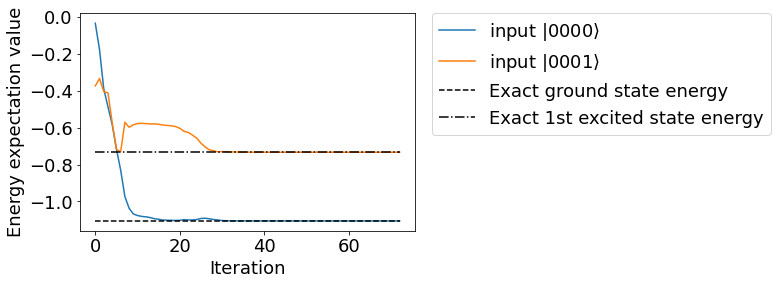

In [8]:
plt.rcParams["font.size"] = 18
plt.plot(exp_history0, label=r"input $|0000\rangle$")
plt.plot(exp_history1, label=r"input $|0001\rangle$")
plt.plot(range(len(exp_history0)), [molecule.fci_energy]*len(exp_history0), linestyle="dashed", color="black", label="Exact ground state energy")
plt.plot(range(len(exp_history1)), [eigval[1]]*len(exp_history1), linestyle="-.", color="black", label="Exact 1st excited state energy")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)
plt.show()